# Load the data set

In [3]:
import json
import re

# Load the dataset containing metadata from arXiv
dataset = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"

In [4]:
import pandas as pd

# Read the JSON file into a Pandas DataFrame
arxiv_df = pd.read_json(dataset, lines=True)
print(len(arxiv_df))

# Drop unnecessary columns
arxiv_df.drop(columns=['journal-ref', 'doi','report-no','submitter','license','comments'], inplace=True)
# Remove rows with missing values
arxiv_df.dropna(inplace=True)
print(len(arxiv_df))

2468403
2468403


In [3]:
# Show the columns
print (arxiv_df.columns)

Index(['id', 'authors', 'title', 'categories', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')


In [4]:
# Show the datafarme
arxiv_df

,id,authors,title,categories,abstract,versions,update_date,authors_parsed
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"
...,...,...,...,...,...,...,...,...
2468398,supr-con/9608008,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm..."
2468399,supr-con/9609001,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N..."
2468400,supr-con/9609002,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n..."
2468401,supr-con/9609003,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te..."


In [5]:
# Function to count the number of authors
def count_authors(authors_list):
    return len(authors_list)

# Apply the count_authors function to create a new column 'num_authors' in the DataFrame
arxiv_df['num_authors'] = arxiv_df['authors_parsed'].apply(count_authors)
arxiv_df

,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",4
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]",1
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]",1
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2
...,...,...,...,...,...,...,...,...,...
2468398,supr-con/9608008,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm...",7
2468399,supr-con/9609001,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N...",4
2468400,supr-con/9609002,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n...",3
2468401,supr-con/9609003,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te...",1


# Show the chart of average authors count per year

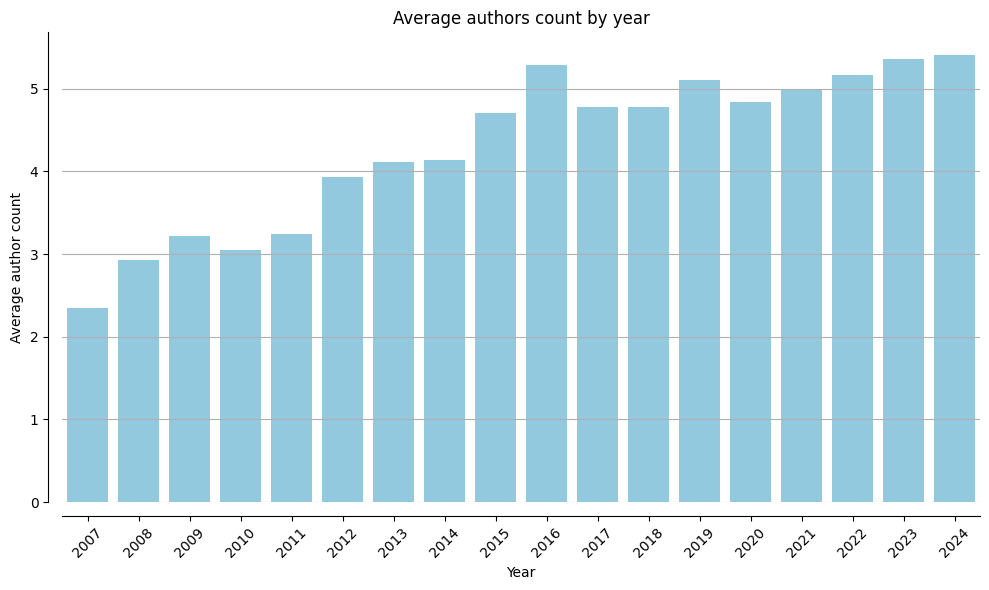

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert 'update_date' to datetime format
arxiv_df['update_date'] = pd.to_datetime(arxiv_df['update_date'])

# Extract year from the 'update_date' column
arxiv_df['year'] = arxiv_df['update_date'].dt.year

# Group by year and calculate the average author count
average_author_count_by_year = arxiv_df.groupby('year')['num_authors'].mean().reset_index()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='num_authors', data=average_author_count_by_year, color='skyblue',zorder=0)

sns.despine(offset=10, trim=False)
plt.title('Average authors count by year')
plt.xlabel('Year')
plt.ylabel('Average author count')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Add gridlines on y-axis
plt.tight_layout()
plt.savefig('average_authors_count_by_year.png')
# show the chart
plt.show()

# Show average versions count per year

In [7]:
# Function to count the number of versions
def count_versions(versions_list):
    return len(versions_list)

# Apply the count_versions function to create a new column 'num_versions' in the DataFrame
arxiv_df['num_versions'] = arxiv_df['versions'].apply(count_versions)

arxiv_df

,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,num_versions
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",4,2008,2
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]",1,2008,3
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]",1,2007,1
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
2468398,supr-con/9608008,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm...",7,2009,1
2468399,supr-con/9609001,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N...",4,2016,1
2468400,supr-con/9609002,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n...",3,2009,1
2468401,supr-con/9609003,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te...",1,2009,1


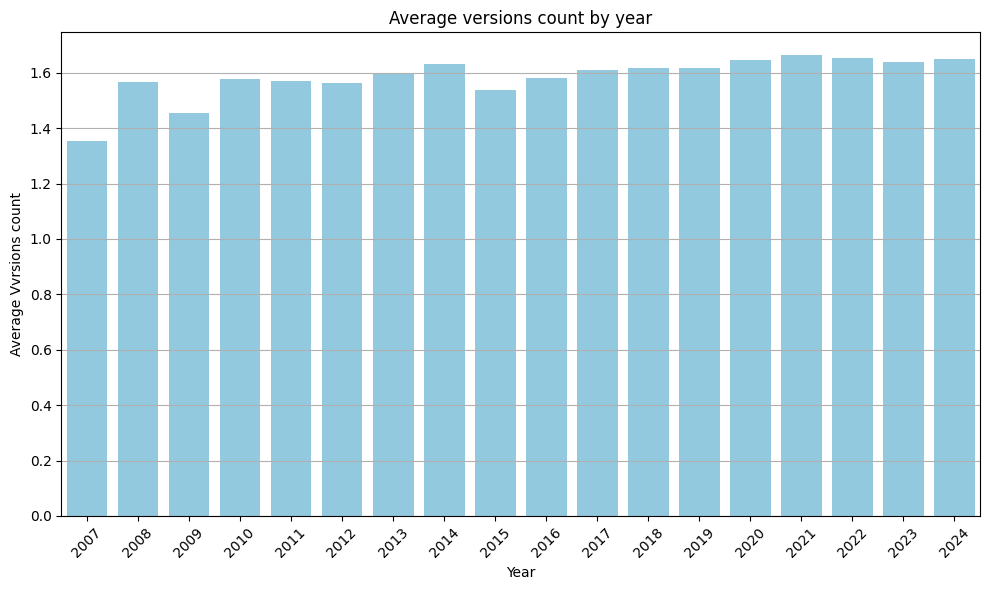

In [8]:
# Group by year and calculate the average verisons count
average_versions_count_by_year = arxiv_df.groupby('year')['num_versions'].mean().reset_index()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='num_versions', data=average_versions_count_by_year, color='skyblue')
plt.title('Average versions count by year')
plt.xlabel('Year')
plt.ylabel('Average Vvrsions count')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Add gridlines on y-axis
plt.tight_layout()
plt.savefig('average_versions_count_by_year.png')
plt.show()

In [9]:
# Install packages for web scraping
!pip install beautifulsoup4
!pip install requests

Getting the sub-category name

In [7]:
import requests
from bs4 import BeautifulSoup

# Send an HTTP GET request to the URL
response = requests.get("https://arxiv.org/category_taxonomy")

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the div containing the category taxonomy
    taxonomy_div = soup.find('div', id='category_taxonomy_list')
    
    # Initialize an empty dictionary to store the sub-category and its father category
    category_dict = {}
    
    # Find all h2 tags (father categories)
#     father_categories = taxonomy_div.find_all(['h2','h3'], class_='accordion-head')
    father_categories_h2 = taxonomy_div.find_all('h2', class_='accordion-head')
    father_categories_h3 = taxonomy_div.find_all('h3', class_='column is-one-fifth')
    
    # Combine both lists of father categories
    father_categories = father_categories_h2 + father_categories_h3
    
    # Iterate over each father category
    for father_category in father_categories:
        # Extract father category name
        father_category_name = father_category.text.strip()
        
        # Find all h4 tags (sub-categories) within the current father category
        sub_categories = father_category.find_next_sibling().find_all('h4')

        # Iterate over each sub-category
        for sub_category in sub_categories:
            # Extract sub-category name
            sub_category_name = sub_category.text.strip()
            
            # Extract sub-category code
            sub_category_code = sub_category_name.split()[0]
            
            # Add the sub-category and its father category to the dictionary
            category_dict[sub_category_code] = father_category_name

    # Display the dictionary
    print(category_dict)
else:
    # Display an error message if the request was not successful
    print("Failed to retrieve webpage content. Status code:", response.status_code)

{'cs.AI': 'Computer Science', 'cs.AR': 'Computer Science', 'cs.CC': 'Computer Science', 'cs.CE': 'Computer Science', 'cs.CG': 'Computer Science', 'cs.CL': 'Computer Science', 'cs.CR': 'Computer Science', 'cs.CV': 'Computer Science', 'cs.CY': 'Computer Science', 'cs.DB': 'Computer Science', 'cs.DC': 'Computer Science', 'cs.DL': 'Computer Science', 'cs.DM': 'Computer Science', 'cs.DS': 'Computer Science', 'cs.ET': 'Computer Science', 'cs.FL': 'Computer Science', 'cs.GL': 'Computer Science', 'cs.GR': 'Computer Science', 'cs.GT': 'Computer Science', 'cs.HC': 'Computer Science', 'cs.IR': 'Computer Science', 'cs.IT': 'Computer Science', 'cs.LG': 'Computer Science', 'cs.LO': 'Computer Science', 'cs.MA': 'Computer Science', 'cs.MM': 'Computer Science', 'cs.MS': 'Computer Science', 'cs.NA': 'Computer Science', 'cs.NE': 'Computer Science', 'cs.NI': 'Computer Science', 'cs.OH': 'Computer Science', 'cs.OS': 'Computer Science', 'cs.PF': 'Computer Science', 'cs.PL': 'Computer Science', 'cs.RO': 'Com

Getting the top-category name

In [8]:
import requests
from bs4 import BeautifulSoup

# URL of the website
url = "https://arxiv.org/category_taxonomy"

# Send an HTTP request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all relevant HTML elements (all <h4> elements)
    category_elements = soup.find_all(['h3','h4'])

    # Create a dictionary to store key-value pairs
    categories_dict = {}

    # Extract information and populate the dictionary
    for category_element in category_elements:
        category_key = category_element.text.strip().split()[0]
        
        # Check if there is a <span> element
        span_element = category_element.find('span')
        if span_element:
            category_value = span_element.text.strip()
        else:
            category_value = "No Value Found"
        
        if (category_value!="No Value Found"):
            categories_dict[category_key] = category_value.strip(')').strip('(')

    # Print the key-value pairs
    for key, value in categories_dict.items():
        print(f"Key: {key}")
        print(f"Value: {value}")
        print()

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

Key: cs.AI
Value: Artificial Intelligence

Key: cs.AR
Value: Hardware Architecture

Key: cs.CC
Value: Computational Complexity

Key: cs.CE
Value: Computational Engineering, Finance, and Science

Key: cs.CG
Value: Computational Geometry

Key: cs.CL
Value: Computation and Language

Key: cs.CR
Value: Cryptography and Security

Key: cs.CV
Value: Computer Vision and Pattern Recognition

Key: cs.CY
Value: Computers and Society

Key: cs.DB
Value: Databases

Key: cs.DC
Value: Distributed, Parallel, and Cluster Computing

Key: cs.DL
Value: Digital Libraries

Key: cs.DM
Value: Discrete Mathematics

Key: cs.DS
Value: Data Structures and Algorithms

Key: cs.ET
Value: Emerging Technologies

Key: cs.FL
Value: Formal Languages and Automata Theory

Key: cs.GL
Value: General Literature

Key: cs.GR
Value: Graphics

Key: cs.GT
Value: Computer Science and Game Theory

Key: cs.HC
Value: Human-Computer Interaction

Key: cs.IR
Value: Information Retrieval

Key: cs.IT
Value: Information Theory

Key: cs.LG
Val

# Explode the list of categories into separate rows


In [9]:
arxiv_df['sep_categories'] = arxiv_df['categories'].str.split()
# Filttering only full year data
arxiv_df= arxiv_df[arxiv_df['year']<2024]
# Explode the list into separate rows
df_exploded = arxiv_df.explode('sep_categories')

# Create a new column with the corresponding values from categories_dict
df_exploded['category'] = df_exploded['sep_categories'].str.strip().map(categories_dict)

# Display the updated DataFrame
print(len(df_exploded))

# Drop rows with missing values
df_exploded.dropna(inplace=True)
# show the dataframe
df_exploded

3977398


,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,sep_categories,category
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",4,2008,hep-ph,High Energy Physics - Phenomenology
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,math.CO,Combinatorics
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,cs.CG,Computational Geometry
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]",1,2008,physics.gen-ph,General Physics
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]",1,2007,math.CO,Combinatorics
...,...,...,...,...,...,...,...,...,...,...,...,...
2468398,supr-con/9608008,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm...",7,2009,cond-mat.supr-con,Superconductivity
2468399,supr-con/9609001,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N...",4,2016,cond-mat.supr-con,Superconductivity
2468400,supr-con/9609002,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n...",3,2009,cond-mat.supr-con,Superconductivity
2468401,supr-con/9609003,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te...",1,2009,cond-mat.supr-con,Superconductivity


In [13]:
# Calculate the number of topics for each publication
arxiv_df['count_topics'] = arxiv_df['categories'].apply(lambda x: len(x.split()))
arxiv_df

/tmp/ipykernel_33/1296202861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arxiv_df['count_topics'] = arxiv_df['categories'].apply(lambda x: len(x.split()))


,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,num_versions,sep_categories,count_topics
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",4,2008,2,[hep-ph],1
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,2,"[math.CO, cs.CG]",2
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]",1,2008,3,[physics.gen-ph],1
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]",1,2007,1,[math.CO],1
4,0704.0005,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2,2013,1,"[math.CA, math.FA]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468398,supr-con/9608008,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm...",7,2009,1,"[supr-con, cond-mat.supr-con]",2
2468399,supr-con/9609001,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N...",4,2016,1,"[supr-con, cond-mat.supr-con]",2
2468400,supr-con/9609002,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n...",3,2009,1,"[supr-con, cond-mat.supr-con]",2
2468401,supr-con/9609003,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te...",1,2009,1,"[supr-con, cond-mat.supr-con]",2


# Show the average categories count chart by year

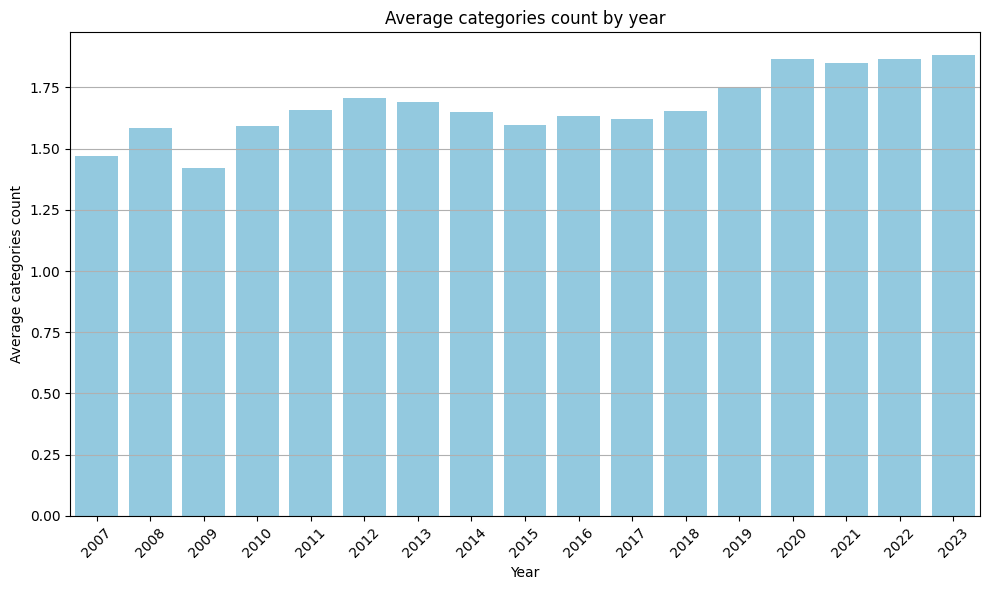

In [14]:
average_topic_count_by_year = arxiv_df.groupby('year')['count_topics'].mean().reset_index()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='count_topics', data=average_topic_count_by_year, color='skyblue',zorder=0)
plt.title('Average categories count by year')
plt.xlabel('Year')
plt.ylabel('Average categories count')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Add gridlines on y-axis
plt.tight_layout()
plt.savefig('average_categories_count_by_year.png')
plt.show()

In [15]:
# show the results
print(average_topic_count_by_year)

    year  count_topics
0   2007      1.469020
1   2008      1.583397
2   2009      1.422354
3   2010      1.593820
4   2011      1.657567
5   2012      1.705893
6   2013      1.690022
7   2014      1.648626
8   2015      1.598216
9   2016      1.632111
10  2017      1.622594
11  2018      1.653423
12  2019      1.751860
13  2020      1.867815
14  2021      1.849930
15  2022      1.867166
16  2023      1.880986


In [10]:
# Create a new column 'top_category' by applying a lambda function to each element in the 'sep_categories' column.
# The lambda function maps each category code to its corresponding top-level category using the 'category_dict' dictionary.
df_exploded['top_category'] = df_exploded['sep_categories'].apply(lambda x: category_dict[x])
df_exploded

,id,authors,title,categories,abstract,versions,update_date,authors_parsed,num_authors,year,sep_categories,category,top_category
0,0704.0001,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",4,2008,hep-ph,High Energy Physics - Phenomenology,Physics
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,math.CO,Combinatorics,Mathematics
1,0704.0002,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2,2008,cs.CG,Computational Geometry,Computer Science
2,0704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]",1,2008,physics.gen-ph,General Physics,Physics
3,0704.0004,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]",1,2007,math.CO,Combinatorics,Mathematics
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468398,supr-con/9608008,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,supr-con cond-mat.supr-con,We report on measurements of the angular dep...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm...",7,2009,cond-mat.supr-con,Superconductivity,Physics
2468399,supr-con/9609001,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,supr-con cond-mat.supr-con,The non-linear microwave surface impedance o...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N...",4,2016,cond-mat.supr-con,Superconductivity,Physics
2468400,supr-con/9609002,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,supr-con cond-mat.supr-con,The vortex contribution to the dc field (H) ...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n...",3,2009,cond-mat.supr-con,Superconductivity,Physics
2468401,supr-con/9609003,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,supr-con cond-mat.supr-con,We show that the density of states in an ani...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te...",1,2009,cond-mat.supr-con,Superconductivity,Physics


# Show the chart of number of publications by category per year

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

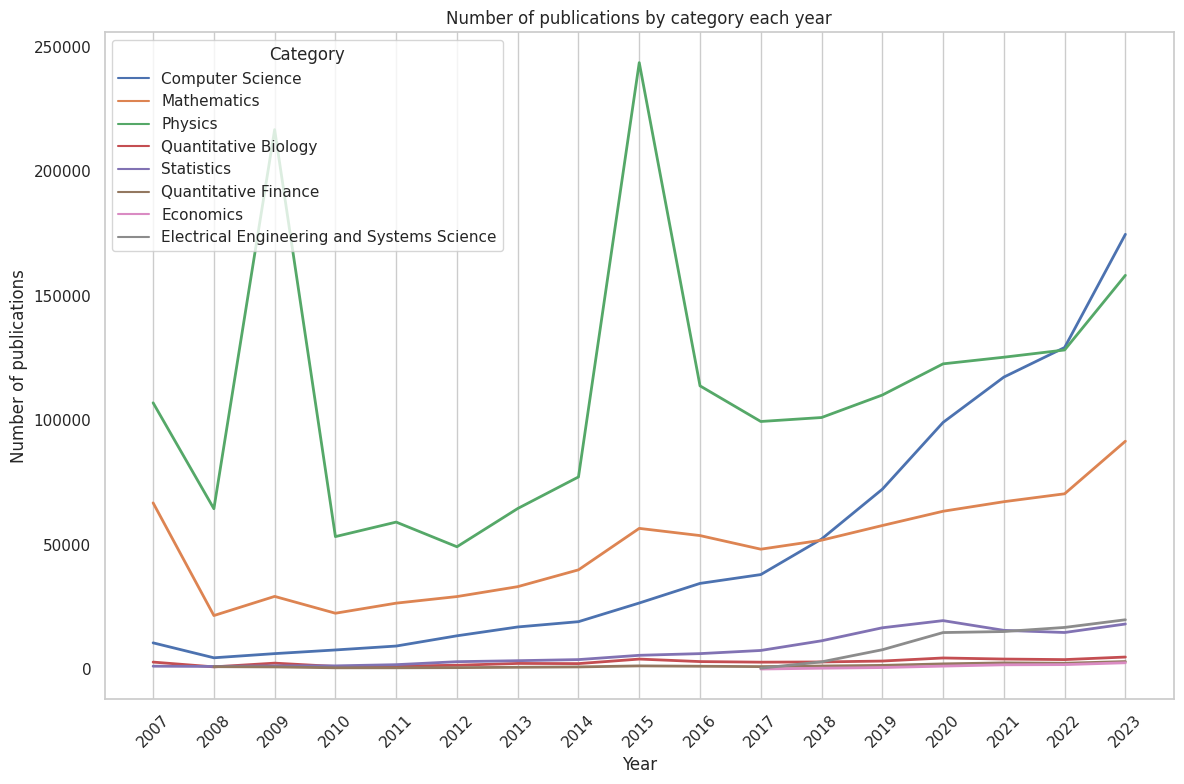

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'year' and 'category' and count the number of publications
publications_by_category_year = df_exploded.groupby(['year', 'top_category']).size().reset_index(name='count')
publications_by_category_year['year'] = publications_by_category_year['year'].astype(str)

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='count', hue='top_category', data=publications_by_category_year,markers=True, dashes=False,lw=2)
plt.title('Number of publications by category each year')
plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.legend(title='Category', loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Add gridlines on y-axis
plt.tight_layout()
plt.savefig('Number_of_Publications_by_Category_by_Year.png')
plt.show()

In [ ]:
# Filter the relevant columns
connected_cat = df_exploded[['id','category','year']]

connected_cat

# Show the top 3 categories each year

/tmp/ipykernel_33/2062085535.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  top_10_categories_each_year['category'].replace(" - ", ' ', regex=True, inplace=True)
/tmp/ipykernel_33/2062085535.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

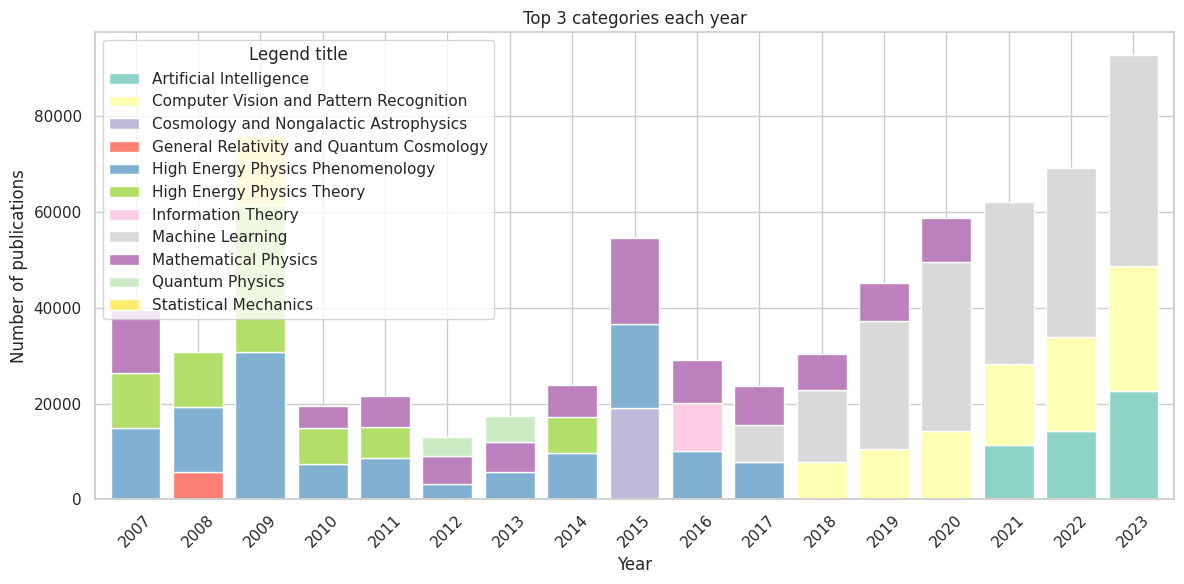

In [19]:
# Group the data by year and category, count the occurrences, and reset index to create a DataFrame with counts
publication_counts = connected_cat.groupby(['year', 'category']).size().reset_index(name='count')

# Sort the DataFrame first by year in ascending order and then by count in descending order
publication_counts_sorted = publication_counts.sort_values(by=['year', 'count'], ascending=[True, False])

# Select the top 3 categories for each year and reset index to create a new DataFrame
top_categories_each_year = publication_counts_sorted.groupby('year').head(3).reset_index()

# Select the top 10 categories for each year and reset index to create another DataFrame
top_10_categories_each_year = publication_counts_sorted.groupby('year').head(10).reset_index()

# Replace any occurrence of " - " with a space in the 'category' column using regular expressions
top_10_categories_each_year['category'].replace(" - ", ' ', regex=True, inplace=True)
top_categories_each_year['category'].replace(" - ", ' ', regex=True, inplace=True)

# Pivot the DataFrame to create a new DataFrame suitable for a stacked bar plot
pivot_df = top_categories_each_year.pivot(index='year', columns='category', values='count')

# Plot the stacked bar plot with specified parameters
pivot_df.plot(kind='bar', stacked=True, colormap='Set3', width=0.8, figsize=(12, 6))
plt.title('Top 3 categories each year')  # Set plot title
plt.xlabel('Year')  # Set x-axis label
plt.ylabel('Number of publications')  # Set y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Legend title', loc='upper left')  # Set legend title and adjust position

plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.savefig('Top 3 categories each year.png')  # Save the plot as an image
plt.show()  # Display the plot


In [20]:
print(top_categories_each_year)

    index  year                                  category  count
0      57  2007         High Energy Physics Phenomenology  14872
1      70  2007                      Mathematical Physics  13048
2      58  2007                High Energy Physics Theory  11558
3     180  2008         High Energy Physics Phenomenology  13642
4     181  2008                High Energy Physics Theory  11488
5     170  2008  General Relativity and Quantum Cosmology   5704
6     314  2009                High Energy Physics Theory  30830
7     313  2009         High Energy Physics Phenomenology  30689
8     376  2009                     Statistical Mechanics  14444
9     450  2010                High Energy Physics Theory   7555
10    449  2010         High Energy Physics Phenomenology   7438
11    463  2010                      Mathematical Physics   4590
12    589  2011         High Energy Physics Phenomenology   8575
13    590  2011                High Energy Physics Theory   6632
14    603  2011          

In [21]:
# show the top 10 categories each year
top_10_categories_each_year

,index,year,category,count
0,57,2007,High Energy Physics Phenomenology,14872
1,70,2007,Mathematical Physics,13048
2,58,2007,High Energy Physics Theory,11558
3,104,2007,Quantum Physics,10485
4,2,2007,Algebraic Geometry,7006
...,...,...,...,...
165,2348,2023,Mathematical Physics,13216
166,2407,2023,Systems and Control,11949
167,2363,2023,Numerical Analysis,11155
168,2333,2023,High Energy Physics Theory,9614


In [25]:
!pip install -U kaleido
!pip install fiftyone -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.9 MB/s eta 0:00:00:00:0100:01

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


In [27]:
!pip install plotly
!conda install -c conda-forge python-kaleido -y

Channels:
 - conda-forge
 - rapidsai
 - nvidia
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - python-kaleido


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    kaleido-core-0.2.1         |       h3644ca4_0        59.2 MB  conda-forge
    mathjax-2.7.7              |       ha770c72_3        21.2 MB  conda-forge
    nspr-4.35                  |       h27087fc_0         222 KB  conda-forge
    nss-3.97                   |       h1d7d5a4_0         1.9 MB  conda-forge
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    python-kaleido-0.2.1       |     pyhd8ed1ab_0          18 KB  

In [30]:
# Import necessary libraries for plotting
import plotly.graph_objects as go  # Plotly graph objects
import plotly.io as pio  # Plotly I/O
import plotly.express as px  # Plotly express for easy plotting

# Replace spaces in the 'category' column with '<br>' to enable multiline display in the treemap
top_10_categories_each_year['v_cat'] = top_10_categories_each_year['category'].str.replace(' ', '<br>')

# Create a new Plotly figure object
fig = go.Figure()

# Create a treemap using Plotly express with specified parameters
fig = px.treemap(top_10_categories_each_year,  # DataFrame to use for plotting
                 path=['year', 'v_cat'],  # Define hierarchy of categories
                 values='count',  # Define values for treemap tiles
                 title='Treemap of Categories by Year',  # Set plot title
                 branchvalues='total',  # Specify how values are aggregated
                 width=1600,  # Set width of the plot
                 height=1200  # Set height of the plot
                )

# Update traces of the treemap to include label and value information, and set text and pathbar font sizes
fig.update_traces(textinfo='label+value',  # Display label and value on treemap tiles
                  selector=dict(type='treemap'),  # Select treemap traces
                  textfont_size=12,  # Set text font size
                  pathbar_textfont_size=12  # Set pathbar text font size
                 )

# Display the treemap
fig.show()

# Write the treemap as an image file with specified scale, width, and height
fig.write_image("categories_treemap.png", scale=6, width=1600, height=900)


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [31]:
# show connected categories dataframe
connected_cat

,id,category,year
0,0704.0001,High Energy Physics - Phenomenology,2008
1,0704.0002,Combinatorics,2008
1,0704.0002,Computational Geometry,2008
2,0704.0003,General Physics,2008
3,0704.0004,Combinatorics,2007
...,...,...,...
2468398,supr-con/9608008,Superconductivity,2009
2468399,supr-con/9609001,Superconductivity,2016
2468400,supr-con/9609002,Superconductivity,2009
2468401,supr-con/9609003,Superconductivity,2009


# Show the most common category each year

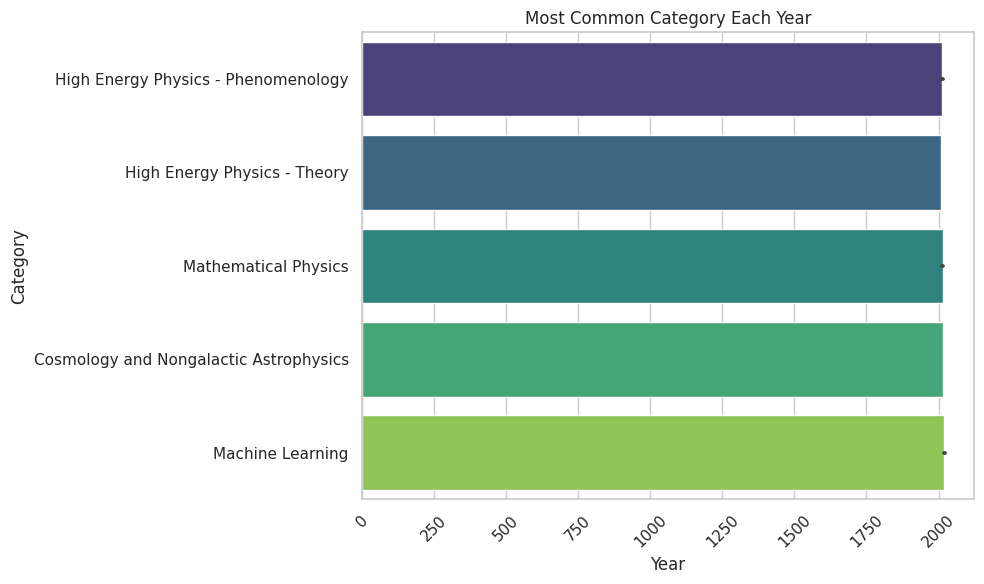

In [32]:
# Group the DataFrame by 'year' and find the most common category for each year
most_common_category = connected_cat.groupby('year')['category'].agg(lambda x: x.mode()[0]).reset_index()

# Display the DataFrame showing the most common category for each year
most_common_category

# Plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.barplot(x='year', y='category', data=most_common_category, palette='viridis')  # Create a bar plot using Seaborn
plt.title('Most Common Category Each Year')  # Set the title of the plot
plt.xlabel('Year')  # Set the label for the x-axis
plt.ylabel('Category')  # Set the label for the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()  # Display the plot


In [20]:
# Prepare dataframe for connection graph
network_connected_cat = connected_cat.groupby('id')

NameError: name 'connected_cat' is not defined

# Show the top 40 Connected Categories

In [34]:
# Import necessary libraries
import networkx as nx
import plotly.graph_objects as go
from itertools import combinations

# Create an empty graph
G = nx.Graph()

# Iterate over each group in the grouped DataFrame
for idx in list(network_connected_cat.groups.keys()):
    # Get the length of the group
    cat_len = len(network_connected_cat.get_group(idx))
    # Check if the group has more than one category
    if cat_len > 1:
        # Generate pairs of combinations of categories within the group
        pairs = list(combinations(list(range(0, cat_len)), 2))
        # Add edges to the graph for each pair of categories
        for pair in pairs:
            category1 = network_connected_cat.get_group(idx).iloc[pair[0]].category
            category2 = network_connected_cat.get_group(idx).iloc[pair[1]].category
            G.add_edge(category1, category2)

# Calculate betweenness centrality for each node
node_betweenness = nx.betweenness_centrality(G)

# Sort nodes based on betweenness centrality and select the top 40
top_nodes = sorted(G.nodes(), key=lambda x: node_betweenness[x], reverse=True)[:40]

# Filter edges to include only those connected to the top nodes
filtered_edges = [(source, target) for source, target in G.edges() if source in top_nodes or target in top_nodes]

# Create a subgraph containing only the top nodes and their connected edges
G_sub = G.subgraph(top_nodes)

# Create positions for the nodes using a spring layout algorithm with a higher k value for a more sparse layout
pos_sub = nx.spring_layout(G_sub, k=2)

# Create edge trace for the filtered edges
edge_x = []
edge_y = []
for edge in G_sub.edges():
    x0, y0 = pos_sub[edge[0]]
    x1, y1 = pos_sub[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create node trace for the top nodes
node_x = []
node_y = []
node_text = []
node_size = []
for node in G_sub.nodes():
    x, y = pos_sub[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)
    node_size.append(node_betweenness[node])

# Define the scaling factor and adjust the size range for nodes
scaling_factor = 10000
min_size = 3
max_size = 100

# Scale the node sizes based on the betweenness centrality
scaled_node_size = [min_size + (s * scaling_factor) for s in node_size]
scaled_node_size = [min(s, max_size) for s in scaled_node_size]

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create node trace
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    text=node_text,
    mode='markers+text',
    hoverinfo='none',
    marker=dict(
        color='#CB1111',
        size=scaled_node_size,
        line=dict(width=2)
    )
)

# Create figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Top 40 Connected Categories',
        titlefont=dict(size=8),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=True),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=True)
    )
)



In [35]:
# Show the figure
fig.show()

In [ ]:
# Save to image file
pio.write_image(fig, 'top_40_connected_categories.png',width=1100, height=700, scale=6)

# Show the top 10 Categoires of betweenness centrality

In [ ]:
# Sort nodes based on betweenness centrality values
sorted_nodes = sorted(node_betweenness.items(), key=lambda x: x[1], reverse=True)

# Select top 10 nodes
top_10_nodes = sorted_nodes[:10]

# Extract node labels and betweenness centrality values
node_labels = [node[0] for node in top_10_nodes]
centrality_values = [node[1] for node in top_10_nodes]

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(node_labels, centrality_values, color='lightblue')
plt.title('Top 10 Categoires of Betweenness Centrality')
plt.xlabel('Category')
plt.ylabel('Betweenness Centrality')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig('top_10_nodes_betweenness_centrality.png')

# Show the figure
plt.show()

In [13]:
# Installing topic modeling packages
!pip install BERTopic
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 7.5 MB/s eta 0:00:00
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=f0c57b545473c31778c14a6db553f2bc698f13ba2c0a52ac8e9b2b1e798c4844
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cytho

In [11]:
# Filter the DataFrame to include only rows where the category is 'Machine Learning'
df_exp_cs = df_exploded[df_exploded['category'] == 'Machine Learning']

# Select specific columns from the filtered DataFrame
df_exp_cs = df_exp_cs[['id', 'abstract', 'year', 'category']]

# Print the length of the filtered DataFrame
print(len(df_exp_cs))


216172


In [12]:
# show the dataframe of the exploded computer science  
df_exp_cs

,id,abstract,year,category
670,0704.0671,The problem of statistical learning is to co...,2016,Machine Learning
953,0704.0954,"In a sensor network, in practice, the commun...",2009,Machine Learning
1019,0704.1020,The on-line shortest path problem is conside...,2007,Machine Learning
1027,0704.1028,Ordinal regression is an important type of l...,2007,Machine Learning
1138,0704.1139,This paper explores the following question: ...,2009,Machine Learning
...,...,...,...,...
2444645,q-bio/0401033,One of the major successes in computational ...,2009,Machine Learning
2444684,q-bio/0402029,Advances in statistical learning theory have...,2007,Machine Learning
2446093,q-bio/0610040,Much recent work in bioinformatics has focus...,2007,Machine Learning
2447800,quant-ph/0011122,The probability distribution P from which th...,2007,Machine Learning


Prepare the data for topic modeling

In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bertopic import BERTopic
import vaex

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize the abstracts and remove stop words using NLTK
stop_words = set(stopwords.words('english'))

# Prepare and clean the text before processing
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the abstract column and convert to veax df
vaex_arxiv_df = vaex.from_pandas(df_exp_cs)
vaex_arxiv_df['cleaned_abstract'] = vaex_arxiv_df['abstract'].apply(preprocess_text)

2024-05-01 06:39:17.464890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 06:39:17.465040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 06:39:17.627630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Convert the cleaned abstracts to a list
abstracts_list = vaex_arxiv_df['cleaned_abstract'].tolist()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt

# Vectorize the text data
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(abstracts_list)

# Apply online LDA
num_topics = 10  
batch_size = 1000  
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=42, batch_size=batch_size)
lda_model.fit(X)

# Get the most common words for each topic
topic_words = []
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    topic_words.append([feature_names[i] for i in top_words_idx])

# Show the top common words across all topics in machine learning

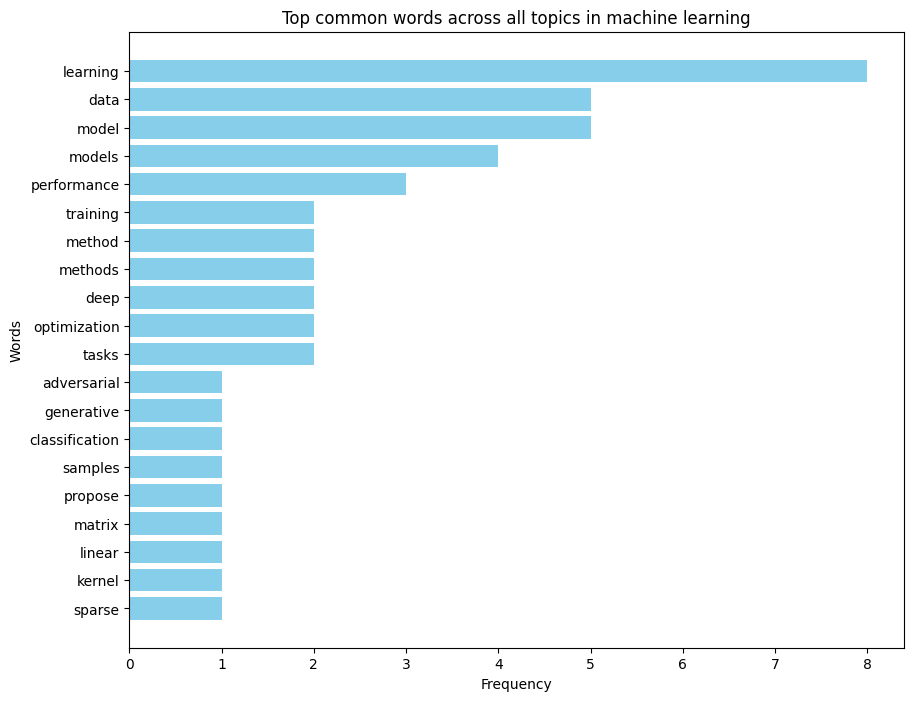

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten the list of top words for all topics
all_topic_words = [word for topic in topic_words for word in topic]

# Count the frequency of each word
word_counts = Counter(all_topic_words)

# Sort the words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 words and their frequencies
top_words = [word[0] for word in sorted_words[:20]]
word_frequencies = [word[1] for word in sorted_words[:20]]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_words, word_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top common words across all topics in machine learning')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent words at the top
plt.savefig('Most_common_topics_in_Machine_Learing.png')
plt.show()

In [15]:
from bertopic import BERTopic
import random

# Random the list
random.shuffle(abstracts_list)

# Select a random subset of 10,000 items
subset_abstracts_list = random.sample(abstracts_list, 10000)

# Initialize and fit the BERTopic model with the subset
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(subset_abstracts_list)

# Get information about the topics
topic_info = topic_model.get_topic_info()
print(len(topic_info))  # Check the number of topics

2024-05-01 06:43:45,232 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-05-01 06:55:23,614 - BERTopic - Embedding - Completed ✓
2024-05-01 06:55:23,618 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-01 06:56:13,104 - BERTopic - Dimensionality - Completed ✓
2024-05-01 06:56:13,106 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-01 06:56:14,001 - BERTopic - Cluster - Completed ✓
2024-05-01 06:56:14,016 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-01 06:56:16,772 - BERTopic - Representation - Completed ✓


37


# Show the topic chart info

In [19]:
# Show first 10 topics words
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4598,-1_data_learning_model_models,"[data, learning, model, models, performance, n...",[paper develops novel hierarchical classifier ...
1,0,377,0_clinical_medical_segmentation_patients,"[clinical, medical, segmentation, patients, im...",[recent studies show deep learning models achi...
2,1,371,1_adversarial_attacks_attack_robustness,"[adversarial, attacks, attack, robustness, exa...",[machine learning systems vulnerable adversari...
3,2,349,2_bayesian_uncertainty_inference_posterior,"[bayesian, uncertainty, inference, posterior, ...",[bayesian neural learning feature rigorous app...
4,3,331,3_rl_policy_reinforcement_learning,"[rl, policy, reinforcement, learning, reward, ...",[paper studies class reinforcement learning ma...
5,4,313,4_gradient_stochastic_convergence_sgd,"[gradient, stochastic, convergence, sgd, optim...",[paper consider class convex optimization prob...
6,5,306,5_graph_graphs_gnns_node,"[graph, graphs, gnns, node, nodes, networks, g...",[graph neural networks gnns show strong expres...
7,6,303,6_forecasting_series_time_model,"[forecasting, series, time, model, energy, mod...",[systems often consist entities interact time ...
8,7,283,7_networks_neural_deep_network,"[networks, neural, deep, network, training, re...",[longstanding goal deep learning research prec...
9,8,200,8_speech_audio_speaker_music,"[speech, audio, speaker, music, model, acousti...",[voice cloning difficult task requires robust ...


In [20]:
# Get the top 10 topic information
topic_info = topic_model.get_topic_info().head(10)  

# Save the topic information to a CSV file
topic_info.to_csv("topic_info.csv", index=False)

In [16]:
# Visualize the topics bar chart
topic_model.visualize_barchart(top_n_topics=11)

In [ ]:
# Assuming topic_model is already initialized and fitted
barchart = topic_model.visualize_barchart(top_n_topics=11)

# Save the visualization as an image file
barchart.write_image("topic_barchart.png", width=1920, height=1080)

In [17]:
# Visualize the the inertopics chart
topic_model.visualize_topics()

In [ ]:
# save the figure to file
visualization = topic_model.visualize_topics()

# Save the visualization as an image file with high resolution (e.g., 1920x1080)
visualization.write_image("topic_visualization.png", width=1920, height=1080)

In [ ]:
topic_info = topic_model.get_topic_info()

# Save the data table to a text file
topic_info.to_csv("topic_data.txt", sep='\t', index=False)